# Лабораторная работа №3

## Используем тот же датасет, что и в предыдущей лабораторной работе

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


file = pd.read_csv("data/StudentsPerformance.csv")

In [53]:
file.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Почистим данные

In [54]:
clean_file = file.dropna()
clean_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


## Классификация данных

В качестве метки выберем пол ученика (gender). Проверим сбалансированность.

In [55]:
class_distribution = clean_file['gender'].value_counts()
print(class_distribution)

gender
female    518
male      482
Name: count, dtype: int64


Данные достаточно сбалансированные, теперь разделим данные на обучающий и тестовый набор. 

In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


X = clean_file[['math score', 'reading score', 'writing score']]
Y = clean_file['gender']
le = LabelEncoder()
Y = le.fit_transform(Y)

ss = StandardScaler()
X = ss.fit_transform(X)
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, stratify=Y)

## Теперь найдем kNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


grid_params = { 'n_neighbors': [i for i in range(1, 40)],
	'weights': ['uniform','distance'],
	'metric': ['minkowski', 'euclidean', 'manhattan'],
}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)

gs_res = gs.fit(X_tr, Y_tr)
metric = gs_res.best_params_['metric']
weights = gs_res.best_params_['weights']
n_neighbors = gs_res.best_params_['n_neighbors']
print(gs_res.best_params_)

{'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'distance'}


Мы нашли параметры для классификации kNN. Теперь можем построить модель.

In [58]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights).fit(X_tr, Y_tr)
predicted = knn.predict(X_t)

## Проверим результат

#### Оценим точность модели.

In [59]:
actual = Y_t

count_right = 0
count_wrong = 0
for i in range(len(actual)):
    if actual[i] == predicted[i]:
        count_right += 1
    else:
        count_wrong += 1

acc = count_right / (count_right + count_wrong)
print(f'Accuracy: {(acc * 100):.2f}%')

Accuracy: 84.80%


#### Найдем Precision, Recall и F1.

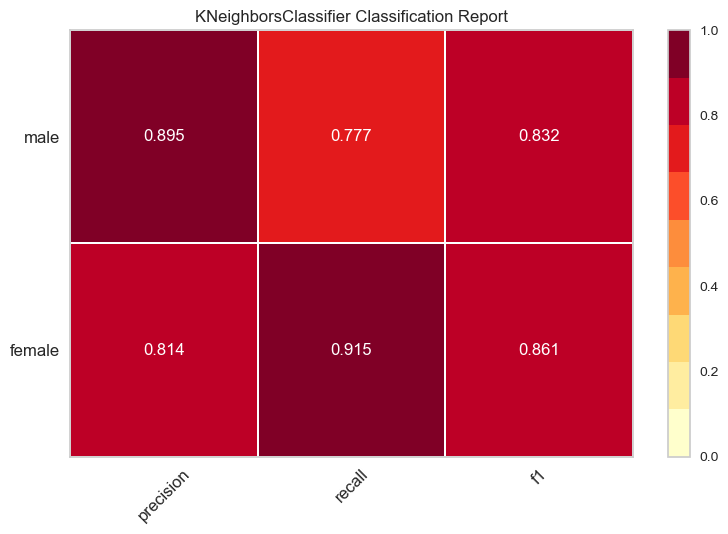

In [60]:
from yellowbrick.classifier import ClassificationReport


visualizer = ClassificationReport(knn, classes=le.classes_)
visualizer.fit(X_tr, Y_tr)
visualizer.score(X_t, Y_t)
fig = visualizer.show()

Эта матрица подтверждает, что модель KNN показывает хорошую производительность, но есть место для улучшений. Учитывая, что precision, recall и F1-score для обоих классов находятся в диапазоне ~82-86%, модель работает сбалансировано для классов "male" и "female".

#### Построим ROC кривую.

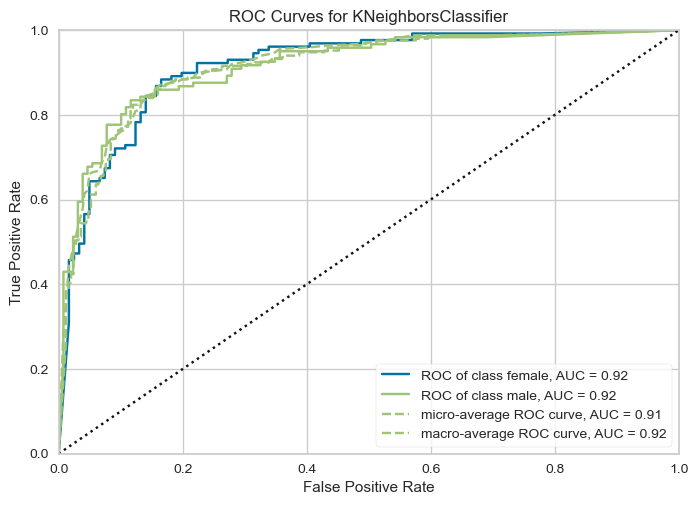

In [61]:
from yellowbrick import ROCAUC


visualizer = ROCAUC(knn, classes=le.classes_)

visualizer.fit(X_tr, Y_tr)
visualizer.score(X_t, Y_t)
graphs = visualizer.show()    

AUC (площадь под кривой) для всех классов (male, female), а также для микро- и макро-усреднений составляет 0.92, что говорит о высокой способности модели различать классы.
Кривые расположены близко к верхнему левому углу, что указывает на хорошее соотношение между высокой чувствительностью (True Positive Rate) и низким уровнем ложных срабатываний (False Positive Rate).
Точность данных 84% хорошо коррелирует с качеством ROC-кривой, подтверждая, что модель способна хорошо классифицировать данные, хотя остается небольшой потенциал для улучшения.

## Дерево решений

Теперь посмотрим другой алгоритм классификации.

In [62]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier()
dt.fit(X_tr, Y_tr)
dt_predicted = dt.predict(X_t)

#### Оценим точность модели.

In [63]:
actual = Y_t
count_right = 0
count_wrong = 0
for i in range(len(actual)):
    if actual[i] == dt_predicted[i]:
        count_right += 1
    else:
        count_wrong += 1

acc = count_right / (count_right + count_wrong)
print(f'Accuracy: {(acc * 100):.2f}%')

Accuracy: 79.60%


#### Найдем Precision, Recall и F1.

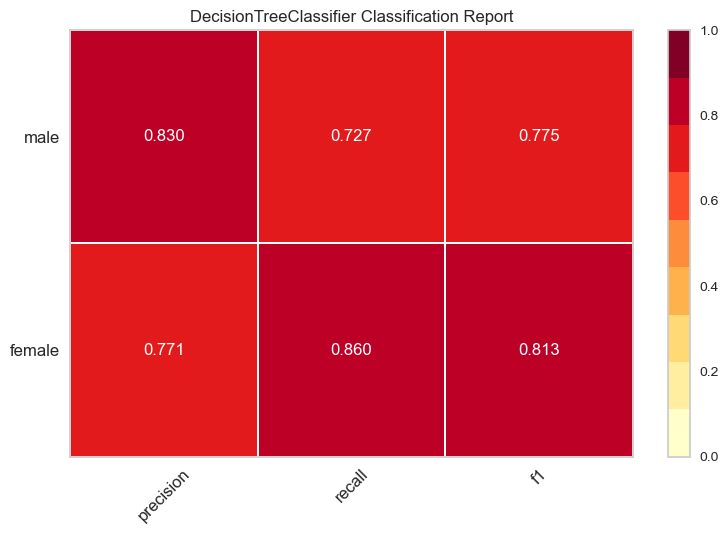

In [64]:
visualizer = ClassificationReport(dt, classes=le.classes_)
visualizer.fit(X_tr, Y_tr)
visualizer.score(X_t, Y_t)
fig = visualizer.show()

Модель показывает схожие результаты для обоих классов, что говорит о сбалансированности предсказаний. Однако точность классификации в 79% может быть улучшена. Значения в матрице соответствуют общей точности данных для этого алгоритма. 

#### Построим ROC кривую.

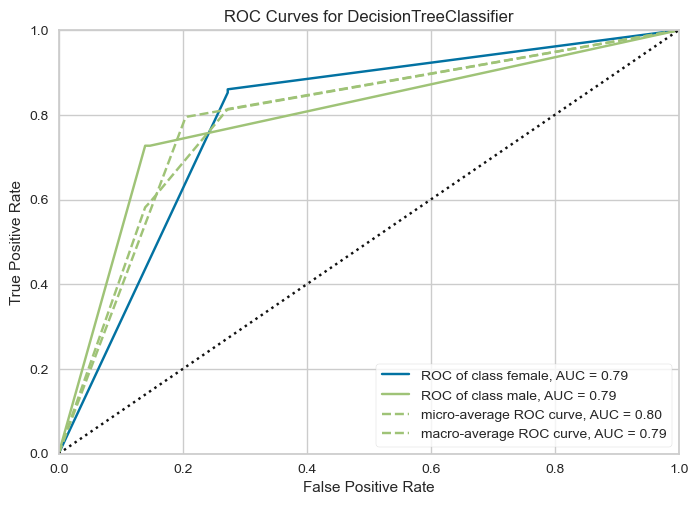

In [65]:
visualizer = ROCAUC(dt, classes=le.classes_)
visualizer.fit(X_tr, Y_tr)
visualizer.score(X_t, Y_t)
graphs = visualizer.show()

График ROC-кривой для алгоритма дерева решений показывает, что модель имеет значение AUC (Area Under Curve) равное 0.80 для обоих классов ("female" и "male"), а также для микро- и макро-усреднений. Это говорит о том, что модель обладает хорошей способностью различать классы, хотя она не идеально точна (значение AUC = 1.0 указывает на идеальную классификацию).

## Вывод

В ходе выполнения данной лабораторной был выбран старый датасет, я почистил его и сделал классификацию, используя kNN и DecisionTreeClassifier. Оценил качество каждого алгоритма, используя такие метрики как: Accuracy, Precision, Recall, F1, ROC-curve. Можно увидеть, что между kNN и DecisionTreeClassifier нет сильных различий. Но при этом kNN показал лучшую точность.